# Multiclass Image Classification

<hr>
<a class="anchor">

## Imports

</a>

In [42]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.optimizers import RMSprop

from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.models import load_model


# model building imports
from keras import Model, Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical

# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler


from keras.layers import RandomContrast, RandomSharpness
from keras.regularizers import l2
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandAugment

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

from library import vis_images

<a class="anchor">

## Preprocess

<a class="anchor">

### Checking metadata for inconsistencies

In [ ]:
# Path to metadata

metadata_path = "C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/metadata.csv"

In [ ]:
metadata = pd.read_csv(metadata_path)

metadata.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [45]:
metadata.shape

(11983, 7)

In [46]:
# Images directory
##### Luis
image_dir_luis = "C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1"
##### Pedro

##### Rodrigo

##### Rafael

##### Inês


# Caminho base
base_image_dir = image_dir_luis

In [47]:
# Criar coluna de caminhos absolutos
metadata['absolute_path'] = metadata['file_path'].apply(lambda x: os.path.join(base_image_dir, x))

# Verificar se o ficheiro existe no disco
metadata['exists'] = metadata['absolute_path'].apply(os.path.exists)

# Contar inválidos (ficheiros que não existem)
invalid_paths = (~metadata['exists']).sum()

# Contar caminhos duplicados
duplicate_paths = metadata['file_path'].duplicated().sum()

# Mostrar info antes da limpeza
print(f"- Invalid paths: {invalid_paths}")
print(f"- Duplicated paths: {duplicate_paths}")
print("\nRemoving the invalid file entries....")
print("All set!\n")

# Limpeza
metadata = metadata[metadata['exists']].drop(columns=['exists'])
metadata = metadata.drop_duplicates(subset='file_path', keep='first')

# Estatísticas pós-limpeza
real_images_on_disk = sum(len(files) for _, _, files in os.walk(base_image_dir))
total_paths_final = len(metadata)


# Mensagem final
print(f"- Total number of entries in metadata: {total_paths_final}")

- Invalid paths: 37
- Duplicated paths: 0

Removing the invalid file entries....
All set!

- Total number of entries in metadata: 11946


We identified 37 paths in the metadata that are invalid, as they do not correspond to any existing image files.
To prevent errors during data splitting, we will remove these entries from the metadata file.

<a class="anchor">

### Train, Val and Test Split

In [48]:
metadata['family'] = metadata['family'].astype(str)  # Ensure it's a string
metadata['file_path'] = metadata['file_path'].astype(str)  # Ensure path is string

In [49]:
# # Codificar a coluna 'family'
# label_encoder = LabelEncoder()
# metadata['label_encoded'] = label_encoder.fit_transform(metadata['family'])

# # (opcional) Guardar o mapa para decodificar depois
# label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [50]:
# Images directory
##### Luis
output_folder_luis = "C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/dataset_split"
##### Pedro
output_folder_pedro = ""
##### Rodrigo
output_folder_rodrigo = ""
##### Rafael
output_folder_rafael = ""
##### Inês
output_folder_ines = ""


output_base = output_folder_luis

In [51]:
# Define output directories
os.makedirs(output_base, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

In [52]:
# Stratified split at image level
from sklearn.model_selection import train_test_split

train_files, temp_files = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, stratify=temp_files['family'], random_state=42)

In [53]:
# def move_files(file_subset, split_name):
#     for _, row in file_subset.iterrows():
#         src_path = os.path.join(image_dir_luis, row['file_path'])  # Construct full path
#         dst_path = os.path.join(output_base, split_name, row['file_path'])
#         os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Ensure folder structure
#         if os.path.exists(src_path):
#             shutil.copy2(src_path, dst_path)
#         else:
#             print(f"Warning: {src_path} not found.")

# # Move images to respective folders
# move_files(train_files, 'train')
# print("Train split completed!")
# move_files(val_files, 'val')
# print("Validation split completed!")
# move_files(test_files, 'test')
# print("Test split completed!\n")

# print("Dataset split completed!")

<a class="anchor">

Data Location

In [54]:
# Pedro
train_path_pedro = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/train"
valid_path_pedro = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/val"
test_path_pedro = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/test"

# Ines
train_path_ines = r"C:\Users\User\Desktop\deeplearning\dataset_split\train"
valid_path_ines = r"C:\Users\User\Desktop\deeplearning\dataset_split\val"
test_path_ines = r"C:\Users\User\Desktop\deeplearning\dataset_split\test"

# Luis
train_path_luis = r"C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/dataset_split/train"
valid_path_luis = r"C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/dataset_split/val"
test_path_luis = r"C:/Users/luisp/OneDrive/Mestrado/1ano/2sem/Deep Learning (DL)/Project/rare_species 1/dataset_split/test"

# Rafael
train_path_rafael = ""
valid_path_rafael = ""
test_path_rafael = ""

# Rodrigo
train_path_rodrigo = ""
valid_path_rodrigo = ""
test_path_rodrigo = ""




##### Define paths to use
train_path = train_path_luis
valid_path = valid_path_luis
test_path = test_path_luis

<a class="anchor">

### Data Loading

In [55]:
train = keras.utils.image_dataset_from_directory(
    directory = train_path,     # train directory path  
    labels="inferred",          # 
    label_mode="categorical",   # One-hot encoding
    batch_size=32,              # CPU Oriented
    image_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    interpolation = "bilinear",
    seed = 42
)

validation = keras.utils.image_dataset_from_directory(
    directory = valid_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

test = keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

Found 8362 files belonging to 202 classes.
Found 1792 files belonging to 202 classes.
Found 1792 files belonging to 202 classes.


<a class="anchor">

### Visualizing Images

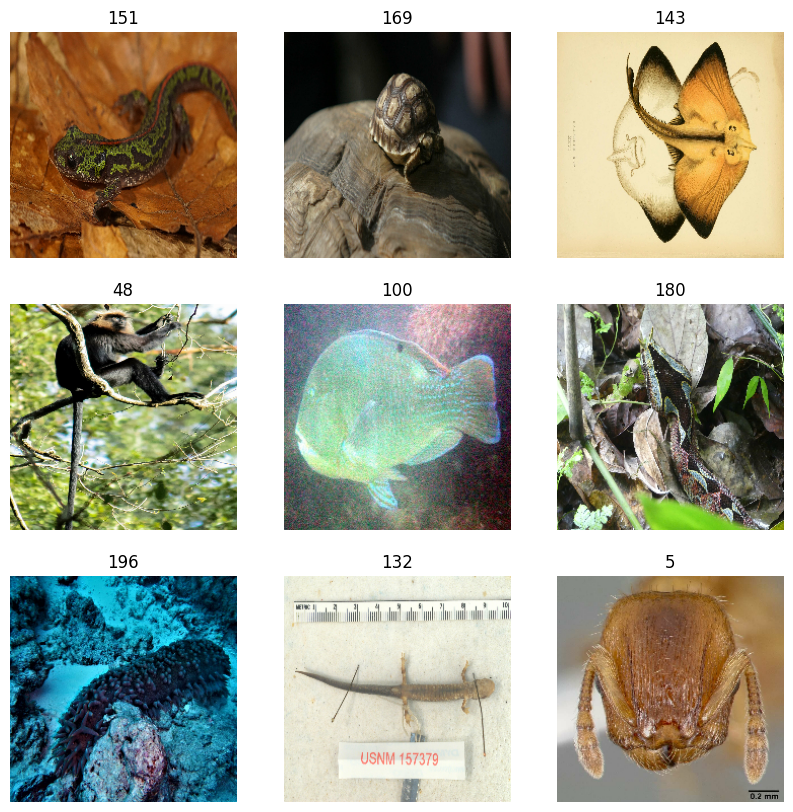

In [56]:
vis_images(train)

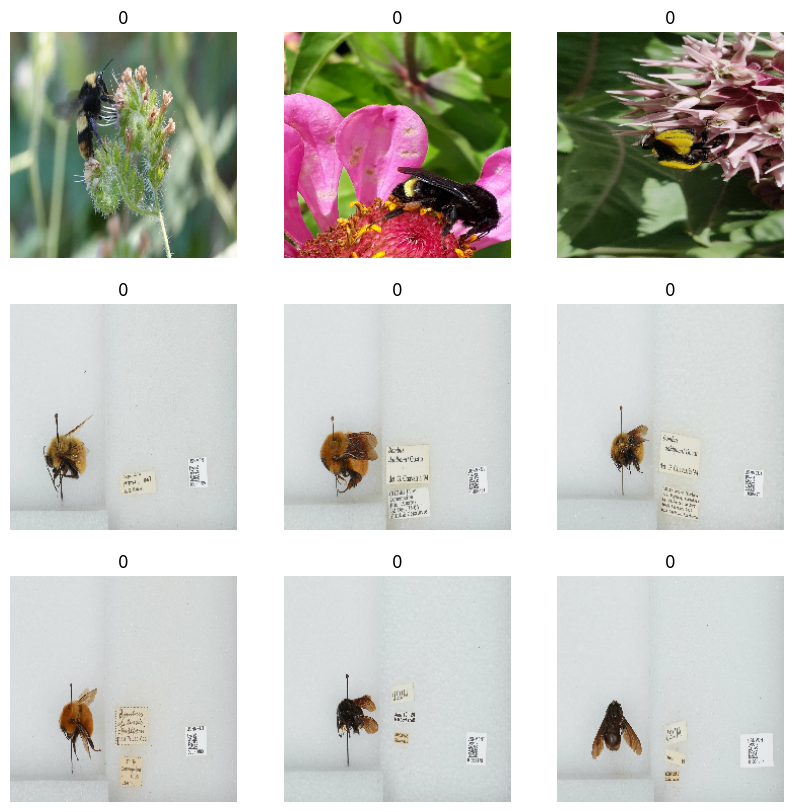

In [57]:
vis_images(validation)

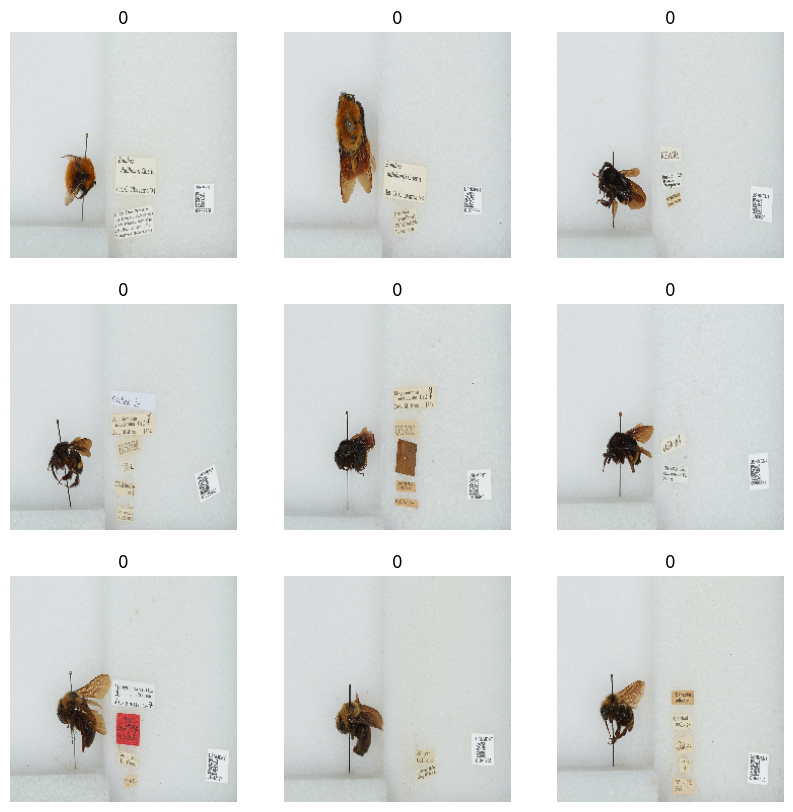

In [58]:
vis_images(test)

<a class="anchor">

## Initial Tests

<a class="anchor">

### Setting up tensorboard

In [59]:
tb_logs = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto"
log_directory = tb_logs + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

<a class="anchor">

### Creating a model

In [60]:
# ## Defining the main class which will be called and will contain our model's parameters.
# ## It inherits from keras.Model class

# ## Why

# class CNN1(Model):

#     def __init__(self, activation = "relu"):
#         # Calling super().__init__ method refers to the parent class Model.
#         # Why is this important? - register the model, it properly initializes the Keras Model class
#         # allowing TF to manage layers, forward propagation, and model metadata correctly.

#         # Allows Model Methods to Work --> Methods like .fit(), .predict(), and .save(), depend
#         # on Model being initialized properly.
#         super().__init__()


#        #### BLOCK 1
#         self.conv1_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_l")
#         self.batch1 = BatchNormalization()
#         self.conv1_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_r")
#         self.batch2 = BatchNormalization()
#         self.maxpool1 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool1")

#         #### BLOCK 2
#         self.conv2_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_l")
#         self.batch3 = BatchNormalization()
#         self.conv2_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_r")
#         self.batch4 = BatchNormalization()
#         self.maxpool2 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool2")

#         #### FLATTEN AND DENSE
#         self.flatten_layer = Flatten()
#         self.dropout_layer = Dropout(rate=0.5)
#         self.batch5 = BatchNormalization()
#         self.dense_layer = Dense(units=202, activation="softmax", name="classification")

#     def call(self, inputs):
#         x = inputs

#         # BLOCK 1
#         x_l = self.conv1_l(x)
#         x_l = self.batch1(x_l)
#         x_r = self.conv1_r(x)
#         x_r = self.batch2(x_r)
#         x = add(x_l,x_r)  
#         x = self.maxpool1(x)

#         # BLOCK 2
#         x_l2 = self.conv2_l(x)
#         x_l2 = self.batch3(x_l2)
#         x_r2 = self.conv2_r(x)
#         x_r2 = self.batch4(x_r2)
#         x = add(x_l2,x_r2)
#         x = self.maxpool2(x)

#         x = self.flatten_layer(x)
#         x = self.dropout_layer(x)
#         x = self.batch5(x)
#         x = self.dense_layer(x)

#         return x

<a class="anchor">

### Callbacks

In [61]:
# my_callbacks = [
#     keras.callbacks.TensorBoard(log_dir=log_directory),
#     keras.callbacks.ModelCheckpoint(
#         filepath = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto.weights.h5",
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#         verbose=1
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor="val_accuracy",
#         patience=5,
#         restore_best_weights = True
#     ),
# #     keras.callbacks.ReduceLROnPlateau(
# #         monitor="val_loss",
# #         factor = 0.2,
# #         mode="auto",
# #         patience=5,
# #         verbose=1,
# #         min_lr = 0.000001
# #     )
#  ]

<a class="anchor">

### Model Summary

In [62]:
# model = CNN1()
# inputs = Input(shape=(224,224,3))
# _ = model.call(inputs)
# model.summary()

Notes:<br>
- Infeasible to run this model, taking more than 10+ hours to run 4 epochs.<br>
- It is clear than while trying both sides of the spectrum, neither a simple model, which trains fast will achieve decent results, nor a very complex one which might have the possibility to achieve the kind of accuracy we aim for, but it is just far too much time to spend, making us unable to run several experiments.<br>
- For these reasons, we conclude that we should probably aim for a Transfer Learning approach, using model's pre-trained weights, and tweaking some architecture details as well as experimenting with Data Augmentation might be the best approach forward.

<a class="anchor">

## Transfer Learning

<a class="anchor">

### DenseNet121

<a class="anchor">

Data Loading for DenseNet121

In [ ]:
train_densenet121 = keras.utils.image_dataset_from_directory(
    directory = train_path,     # train directory path  
    labels="inferred",          # 
    label_mode="categorical",   # One-hot encoding
    batch_size=32,              # CPU Oriented
    image_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    interpolation = "bilinear", # usar tambem "bicubic"
    seed = 42
)

val_densenet121 = keras.utils.image_dataset_from_directory(
    directory = valid_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear" # usar tambem "bicubic"
)

test_densenet121 = keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear" # usar tambem "bicubic"
)

Found 8362 files belonging to 202 classes.
Found 1792 files belonging to 202 classes.
Found 1792 files belonging to 202 classes.


<a class="anchor">

#### Resizing

<a class="anchor">

##### Checking sizes

In [64]:
for images, labels in train_densenet121.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 255.0


In [65]:
for images, labels in val_densenet121.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 255.0


In [66]:
for images, labels in test_densenet121.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 255.0


<a class="anchor">

##### Aplying Normalization / Preprocess_input

In [67]:
train_densenet121 = train_densenet121.map(lambda x,y: (preprocess_input(x), y))
val_densenet121 = val_densenet121.map(lambda x,y: (preprocess_input(x), y))
test_densenet121 = test_densenet121.map(lambda x,y: (preprocess_input(x), y))

In [68]:
# Checking RGB Pixel
for images, labels in train_densenet121.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Min Pixel Value: -2.117904
Max Pixel Value: 2.64


In [69]:
### Checking RGB Pixel 
for images, labels in val_densenet121.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Min Pixel Value: -2.117904
Max Pixel Value: 2.64


In [70]:
### Checking RGB
for images, labels in test_densenet121.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Max Pixel Value:", np.max(images.numpy()))

Min Pixel Value: -2.117904
Max Pixel Value: 2.64


<a class="anchor">

Autotune

In [71]:
AUTOTUNE = tf.data.AUTOTUNE

train = train_densenet121.prefetch(AUTOTUNE)
validation = val_densenet121.prefetch(AUTOTUNE)
test = test_densenet121.prefetch(AUTOTUNE)

<a class="anchor">

Data Augmentation

In [72]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [73]:
# data_augmentation = tf.keras.Sequential([
#     # Flip horizontal (útil para simetria)
#     tf.keras.layers.RandomFlip("horizontal"),

#     # Pequenas rotações (10%)
#     tf.keras.layers.RandomRotation(factor=0.1),

#     # Zoom in e out (até ±20%)
#     tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),

#     # Translação (mover imagem)
#     tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

#     # Variações de brilho e contraste
#     tf.keras.layers.RandomBrightness(factor=0.1),
#     tf.keras.layers.RandomContrast(factor=0.1),

#     # Adição de ruído (simula imagens imperfeitas)
#     tf.keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.03)),

#     # Normalização com preprocess_input (para DenseNet121)
#     tf.keras.layers.Lambda(lambda x: tf.keras.applications.densenet.preprocess_input(x))
# ])


# Função que aplica (sem recriar)
def augment(x, y):
    return data_augmentation(x), y

# Aplicar no dataset
train_densenet121 = train_densenet121.map(augment)

<a class="anchor">

Callbacks

In [84]:
# Callbacks comuns
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("best.keras", save_best_only=True)
]

<a class="anchor">

Build the model: Baseline

In [75]:
# Número de classes (contadas a partir do dataset one-hot)
NUM_CLASSES = train_densenet121.element_spec[1].shape[-1]

In [76]:
def create_densenet121_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model

In [77]:
# Baseline with Data Augmentation
baseline_model_with_aug, base_model = create_densenet121_model()

callbacks[2] = ModelCheckpoint("best_densenet121_baseline_aug.keras", save_best_only=True)

history_baseline_model_with_aug = baseline_model_with_aug.fit(
    train_densenet121,
    validation_data=val_densenet121,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 236s 867ms/step - accuracy: 0.0456 - loss: 5.5905 - val_accuracy: 0.2561 - val_loss: 3.5189 - learning_rate: 5.0000e-04
Epoch 2/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 221s 841ms/step - accuracy: 0.1999 - loss: 3.7626 - val_accuracy: 0.3906 - val_loss: 2.6929 - learning_rate: 5.0000e-04
Epoch 3/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 219s 834ms/step - accuracy: 0.3261 - loss: 2.9536 - val_accuracy: 0.4810 - val_loss: 2.2792 - learning_rate: 5.0000e-04
Epoch 4/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 233s 886ms/step - accuracy: 0.3934 - loss: 2.5577 - val_accuracy: 0.5206 - val_loss: 2.0351 - learning_rate: 5.0000e-04
Epoch 5/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.4520 - loss: 2.2622 - val_accuracy: 0.5558 - val_loss: 1.8881 - learning_rate: 5.0000e-04
Epoch 6/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 244s 925ms/step - accuracy: 0.4975 - loss: 2.0406 - val_accuracy: 0.5742 - val_loss: 1.7819 - learning_rate: 5.0000e-04
Epoch 7/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 221

In [78]:
# Salvar modelos baseline antes de fine-tuning
baseline_model_with_aug.save("baseline_model_with_aug.keras")

<a class="anchor">

Fine-Tuning

In [79]:
def fine_tune_model(model, base_model, fine_tune_at=50, lr=1e-5):
    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [80]:
# Corrigir callback
callbacks[2] = ModelCheckpoint("best_densenet_finetuned_aug.keras", save_best_only=True)

# Fine-tune (descongela últimas layers do base_model)
finetuned_model_with_aug = fine_tune_model(baseline_model_with_aug, base_model)

# Continuar o treino com fine-tuning
history_finetuned_model_with_aug = finetuned_model_with_aug.fit(
    train_densenet121,
    validation_data=val_densenet121,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 251s 912ms/step - accuracy: 0.6172 - loss: 1.3503 - val_accuracy: 0.6613 - val_loss: 1.4192 - learning_rate: 1.0000e-05
Epoch 2/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 231s 878ms/step - accuracy: 0.6390 - loss: 1.2965 - val_accuracy: 0.6641 - val_loss: 1.4154 - learning_rate: 1.0000e-05
Epoch 3/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 236s 897ms/step - accuracy: 0.6443 - loss: 1.2883 - val_accuracy: 0.6685 - val_loss: 1.3993 - learning_rate: 1.0000e-05
Epoch 4/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 234s 890ms/step - accuracy: 0.6569 - loss: 1.2492 - val_accuracy: 0.6708 - val_loss: 1.3881 - learning_rate: 1.0000e-05
Epoch 5/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 238s 904ms/step - accuracy: 0.6563 - loss: 1.2379 - val_accuracy: 0.6735 - val_loss: 1.3784 - learning_rate: 1.0000e-05
Epoch 6/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 236s 896ms/step - accuracy: 0.6700 - loss: 1.2063 - val_accuracy: 0.6763 - val_loss: 1.3702 - learning_rate: 1.0000e-05
Epoch 7/60
262/262 ━━━━━━━━━━━━━━━━━━━━ 

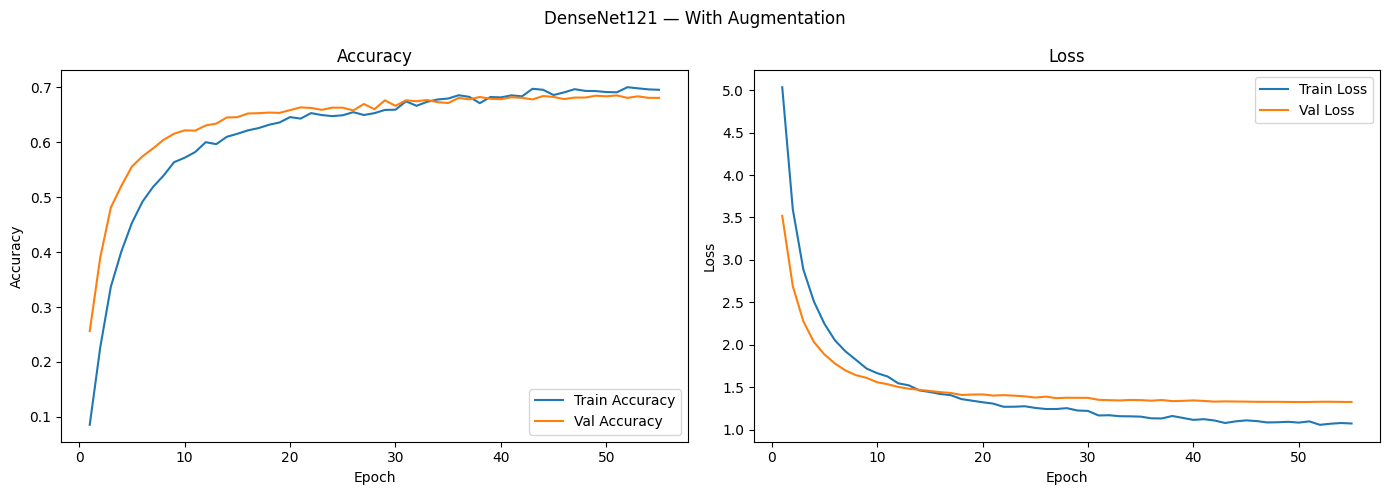

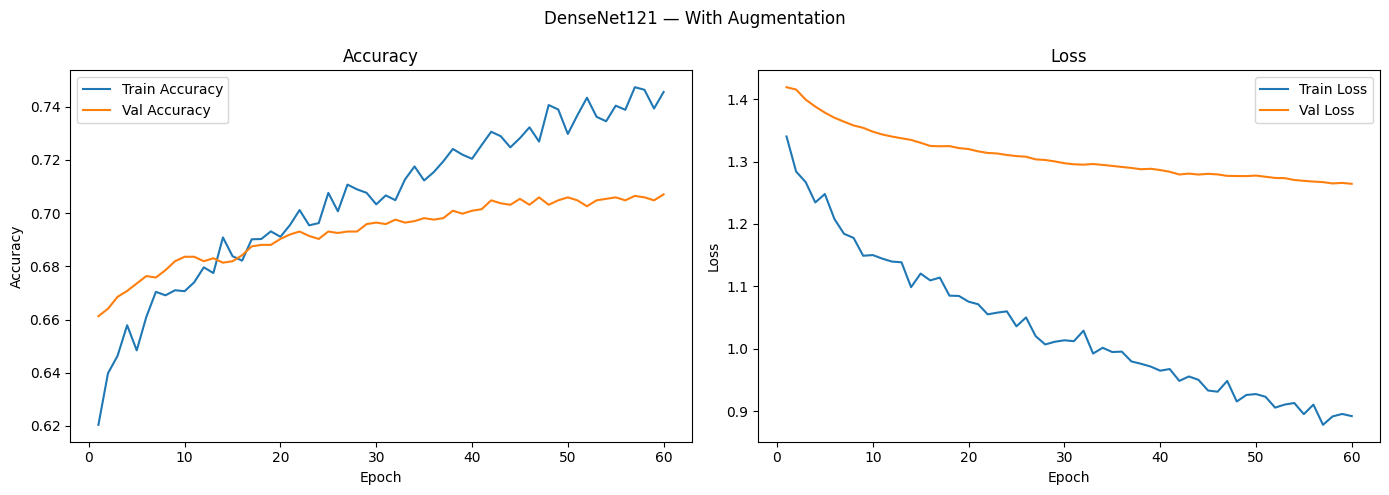

In [81]:
def plot_training(history, label):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14, 5))
    plt.suptitle(f"DenseNet121 — {label}")

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot
plot_training(history_baseline_model_with_aug, "With Augmentation")
plot_training(history_finetuned_model_with_aug, "With Augmentation")

F1-score

In [82]:
from sklearn.metrics import f1_score
import numpy as np

def evaluate_f1_macro(model, test_dataset, name=""):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"🎯 Macro F1-score {name}: {f1_macro:.4f}")
    return f1_macro


In [83]:
model_baseline_aug = load_model("baseline_model_with_aug.keras")

f1_baseline_aug = evaluate_f1_macro(model_baseline_aug, test_densenet121, "Baseline With Augmentation")

f1_ft_aug = evaluate_f1_macro(finetuned_model_with_aug, test_densenet121, "Fine-tuned With Augmentation")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 